In [1]:
import sys
 
# setting path
sys.path.append('../')
import csv

from utils.dataloaders import MIDIEvalDataLoader
from utils.display import display_dicom
from dcm_anonymizers.utils import list_all_files
from dcm_anonymizers.phi_detectors import DcmRobustPHIDetector

from pathlib import Path

In [2]:
root_data_dir = '/home/r079a/Desktop/de-identification/dataset'

loader = MIDIEvalDataLoader(
    rawimagespath=Path(root_data_dir, 'images/manifest-1617826555824'),
    deidimagespath=Path(root_data_dir, 'images-2/manifest-1617826161202'),
    uidsmappath=Path(root_data_dir, 'Pseudo-PHI-DICOM-Dataset-uid_crosswalk.csv'),
)

In [3]:
(rawdcm, metadata), (deiddcm, deiddcm_metadata) = loader.get_raw_n_deid_patient(4, include_metadata=True)

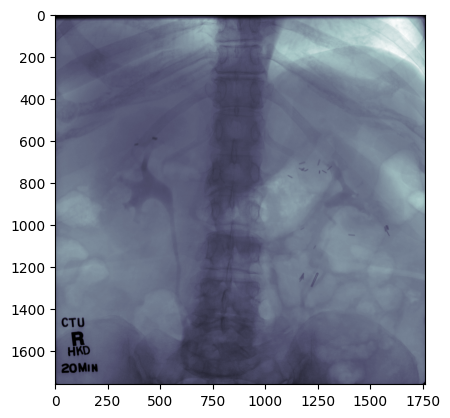

In [4]:
display_dicom(rawdcm[0])

In [5]:
dataset = rawdcm[0]

for element in dataset:
    if element.VR == 'OW':
            continue
    if element.VR in ("LO", "LT", "SH", "PN", "CS", "ST", "UT", "UN") and element.value != "":
        print(element)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'POST_PROCESSED', '', '', '', '', '', '100000']
(0008, 0041) Data Set Subtype                    LO: 'IMA NONE'
(0008, 0050) Accession Number                    SH: '978B4101'
(0008, 0060) Modality                            CS: 'CR'
(0008, 0070) Manufacturer                        LO: 'FUJIFILM Corporation'
(0008, 0080) Institution Name                    LO: 'Kim, Jones and Frazier Medical Center'
(0008, 0081) Institution Address                 ST: '637 Jenkins Via Danielborough, AK 15270'
(0008, 0090) Referring Physician's Name          PN: 'JOHNSTON^BRIDGET'
(0008, 0094) Referring Physician's Telephone Num SH: '199.945.9670'
(0008, 1030) Study Description                   LO: 'CT Urogram w 3D'
(0008, 103e) Series Description                  LO: '= NONE ='
(0008, 1050) Performing Physician's Name         PN: 'MYERS^COREY'
(0008, 2111) Deriv

In [6]:
detector = DcmRobustPHIDetector()

In [7]:
tag = (0x0008, 0x0008)

element = dataset.get(tag)
print(element)

(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'POST_PROCESSED', '', '', '', '', '', '100000']


In [8]:
element_txt = detector.element_to_text(element)
print(element_txt)
detector.detect_entities(element_txt)

Image Type: DERIVED, PRIMARY, POST_PROCESSED, 100000


[('100000', 'PHONE', 46)]

In [9]:
for element in dataset:
    if element.VR == 'OW':
            continue
    if element.VR in ("LO", "LT", "SH", "PN", "CS", "ST", "UT", "UN") and element.value != "":
        print(element)
        entities = detector.detect_entities_from_element(element)
        print(entities)
        print("-----------------------------------------------")

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
[]
-----------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'POST_PROCESSED', '', '', '', '', '', '100000']
[('100000', 'PHONE', 46)]
-----------------------------------------------
(0008, 0041) Data Set Subtype                    LO: 'IMA NONE'
[]
-----------------------------------------------
(0008, 0050) Accession Number                    SH: '978B4101'
[('978B4101', 'ID', 18)]
-----------------------------------------------
(0008, 0060) Modality                            CS: 'CR'
[]
-----------------------------------------------
(0008, 0070) Manufacturer                        LO: 'FUJIFILM Corporation'
[('FUJIFILM Corporation', 'PATORG', 14)]
-----------------------------------------------
(0008, 0080) Institution Name                    LO: 'Kim, Jones and Frazier Medical Center'
[('Kim, Jones', 'PATIENT', 18), ('Frazier Medical Center', 'HOSPIT

In [10]:
import pydicom
import re

In [11]:
def extract_text_tags(dataset: pydicom.Dataset):
    all_texts = ''
    tag_position_map = {}
    tag_seperator = ',\n'
    
    for element in dataset:
        if element.VR == 'OW':
            continue
        # if element.tag.is_private:
        if element.VR in ("LO", "LT", "SH", "PN", "CS", "ST", "UT", "UN") and element.value != "":
            # if element.VR == "UN" and not self.is_utf8(element):
            #     continue
            element_val = detector.process_element_val(element)
            element_name = detector.processed_element_name(element.name)

            element_text = f"{element_name}: {element_val}"
            
            # prev text + element_name + colon
            start = len(all_texts) + len(element_name) + 1

            # if not the first item, then additional 2 chars for comma+space
            if all_texts != '':
                start += len(tag_seperator)
                
            end = start + len(element_val) + 1
            
            tag_position_map[element.tag] = (start, end)
            
            if all_texts == '':
                all_texts += f"{element_text}"
            else:
                all_texts += f"{tag_seperator}{element_text}"

            assert all_texts[start:end] == f" {element_val}", f"{all_texts[start:end]} != {element_val}"
    
    return all_texts, tag_position_map

In [12]:
all_texts, tag_map = extract_text_tags(dataset)

In [13]:
all_texts

"Specific Character Set: ISO_IR 100,\nImage Type: DERIVED, PRIMARY, POST_PROCESSED, 100000,\nData Set Subtype: IMA NONE,\nAccession Number: 978B4101,\nModality: CR,\nManufacturer: FUJIFILM Corporation,\nInstitution Name: Kim, Jones and Frazier Medical Center,\nInstitution Address: 637 Jenkins Via Danielborough, AK 15270,\nReferring Physician's Name: JOHNSTON BRIDGET,\nReferring Physician's Telephone Numbers: 199.945.9670,\nStudy Description: CT Urogram w 3D,\nSeries Description: = NONE =,\nPerforming Physician's Name: MYERS COREY,\nDerivation Description: G1.1D#1.60+0.50,R3Q0.1,C*1.0*1.0,\nPrivate Creator: FDMS 1.0,\nPrivate Creator: SPI RELEASE 1,\nExposure Unit Type Code: E2,\nBlackening Process Flag: 00,\nProcessing Information Flag: 0000,\nPatient's Name: POOLE OLIVIA,\nPatient ID: 4025360156,\nPatient's Sex: F,\nPatient's Address: 503 Farmer Squares Suite 087 Elizabethbury, HI 52911,\nPrivate Creator: SPI RELEASE 1,\nPrivate Creator: CTP,\nPrivate tag data: Pseudo-PHI-DICOM-Data,\

In [14]:
tag_map

{(0008, 0005): (23, 34),
 (0008, 0008): (47, 88),
 (0008, 0041): (107, 116),
 (0008, 0050): (135, 144),
 (0008, 0060): (155, 158),
 (0008, 0070): (173, 194),
 (0008, 0080): (213, 251),
 (0008, 0081): (273, 313),
 (0008, 0090): (342, 359),
 (0008, 0094): (401, 414),
 (0008, 1030): (434, 450),
 (0008, 103e): (471, 480),
 (0008, 1050): (510, 522),
 (0008, 2111): (547, 580),
 (0009, 0010): (598, 607),
 (0009, 0011): (625, 639),
 (0009, 1010): (665, 668),
 (0009, 10f0): (694, 697),
 (0009, 10f1): (727, 732),
 (0010, 0010): (749, 762),
 (0010, 0020): (775, 786),
 (0010, 0040): (802, 804),
 (0010, 1040): (824, 877),
 (0011, 0010): (895, 909),
 (0013, 0010): (927, 931),
 (0013, 1010): (950, 972),
 (0013, 1013): (991, 1000),
 (0018, 0015): (1021, 1028),
 (0018, 1004): (1039, 1050),
 (0018, 1400): (1094, 1105),
 (0018, 1401): (1142, 1147),
 (0018, 1508): (1165, 1170),
 (0019, 0010): (1188, 1197),
 (0019, 1040): (1221, 1224),
 (0019, 1050): (1235, 1237),
 (0021, 0010): (1255, 1264),
 (0021, 1050)

In [15]:
tags_w_entities = detector.detect_enitity_tags_from_text(all_texts, tag_map)

In [16]:
for tag in tags_w_entities:
    element = dataset.get(tag)
    elemval, entity_values = element.value, tags_w_entities[tag]
    
    elemval = detector.safe_str(elemval)
    n_words = len(elemval.split())
    deid_val = elemval[:]
    entity_n_chars = len(''.join(entity_values))
    
    if len(elemval) == entity_n_chars:
        deid_val = ""
    else:
        elemval = "XR CHEST AP PORTABLE for Douglas^Davidson"
        deid_val = elemval[:]
        for entity_val in entity_values:
            if entity_val in deid_val:
                deid_val = deid_val.replace(entity_val, '', 1)
            else:
                entity_pattern = re.sub(r'\s+', '[^a-zA-Z0-9]*', entity_val)
                match = re.search(entity_pattern, deid_val)
                if match:
                    deid_val = deid_val.replace(match.group(), '', 1)
                else:                
                    print(f"{entity_val} not found in the original value {elemval}")

    print(deid_val)



Kim, Jones not found in the original value XR CHEST AP PORTABLE for Douglas^Davidson
Frazier Medical Center not found in the original value XR CHEST AP PORTABLE for Douglas^Davidson
XR CHEST AP PORTABLE for Douglas^Davidson






503 Farmer Squares not found in the original value XR CHEST AP PORTABLE for Douglas^Davidson
Elizabethbury, HI 52911 not found in the original value XR CHEST AP PORTABLE for Douglas^Davidson
XR CHEST AP PORTABLE for Douglas^Davidson






In [17]:
sample_elem = (0x0008, 0x1030)
element = dataset.get(sample_elem)

In [18]:
detector.deidentified_element_val(element)

'CT Urogram w 3D'

In [19]:
from dcm_anonymizers.tcia_deid import DCMTCIAAnonymizer

In [20]:
anonymizer = DCMTCIAAnonymizer(phi_detector=detector)

08/21/2024 11:48:52 - DEBUG - dcm_anonymizers.ps_3_3 - PS3.3 init
08/21/2024 11:48:52 - DEBUG - dcm_anonymizers.ps_3_3 - TCIA anonymizer init


In [21]:
# dcm_path = Path(root_data_dir, 'images/manifest-1617826555824', metadata['File Location'])
dcm_path = "/home/r079a/Desktop/de-identification/dataset/images/manifest-1617826555824/Pseudo-PHI-DICOM-Data/3642991663/07-05-1961-345678-PET-CT STUDY for Shelly Wallace-70838/PET-CT SERIES-76598/1-003.dcm"
output_dir = "/home/r079a/Desktop/de-identification/dataset/anonymizer-output/1-003.dcm"

In [22]:
# anonymizer.anonymize(
#     input_path=str(dcm_path),
#     output_path=str(output_dir),
#     custom_actions={},
# )

In [23]:
dataset = pydicom.dcmread(dcm_path)

In [24]:
all_texts, tag_map = extract_text_tags(dataset)
print(all_texts)

Specific Character Set: ISO_IR 100,
Image Type: ORIGINAL, PRIMARY,
Accession Number: 19610707E512330,
Modality: PT,
Manufacturer: GE MEDICAL SYSTEMS,
Institution Name: Collins Medical Center,
Institution Address: 584 Martinez Lake New Edward, AR 53239,
Referring Physician's Name: BENNETT JOSEPH,
Referring Physician's Address: 193 Alicia Locks Apt. 326 West Daleburgh, NV 25588,
Referring Physician's Telephone Numbers: 1-014-099-5877,
Study Description: PET-CT STUDY for Shelly Wallace,
Series Description: PET-CT SERIES,
Performing Physician's Name: MOLINA ALEX,
Operators' Name: RICHARDS BRIANNA,
Manufacturer's Model Name: Discovery LS,
Private Creator: GEMS_PETD_01,
GE Discovery PET Implementation Version Name: GE Advance,
PET compatible_version: 05.00,
GE Advance Patient.software_version: 16.01,
PET compatible_version: 05.00,
PET software_version: 16.01,
PET compatible_version: 05.00,
PET software_version: 16.01,
PET scan_description: PET CT INFERIOR TO SUPERIOR,
PET scanner_desc: Disco

In [25]:
for tag in tag_map.keys():
    tag_range = tag_map[tag]
    print(tag, all_texts[tag_range[0]:tag_range[1]])

(0008, 0005)  ISO_IR 100
(0008, 0008)  ORIGINAL, PRIMARY
(0008, 0050)  19610707E512330
(0008, 0060)  PT
(0008, 0070)  GE MEDICAL SYSTEMS
(0008, 0080)  Collins Medical Center
(0008, 0081)  584 Martinez Lake New Edward, AR 53239
(0008, 0090)  BENNETT JOSEPH
(0008, 0092)  193 Alicia Locks Apt. 326 West Daleburgh, NV 25588
(0008, 0094)  1-014-099-5877
(0008, 1030)  PET-CT STUDY for Shelly Wallace
(0008, 103e)  PET-CT SERIES
(0008, 1050)  MOLINA ALEX
(0008, 1070)  RICHARDS BRIANNA
(0008, 1090)  Discovery LS
(0009, 0010)  GEMS_PETD_01
(0009, 1001)  GE Advance
(0009, 1003)  05.00
(0009, 1004)  16.01
(0009, 1008)  05.00
(0009, 1009)  16.01
(0009, 100b)  05.00
(0009, 100c)  16.01
(0009, 100f)  PET CT INFERIOR TO SUPERIOR
(0009, 1011)  Discovery LS
(0009, 1012)  GE MEDICAL SYSTEMS
(0009, 1014)  Orbital Meatal Line
(0009, 1015)  OM
(0009, 1036)  FDG -- fluorodeoxyglucose
(0009, 103e)  18F
(0009, 1060)  05.00
(0009, 1061)  16.01
(0009, 1079)  05.00
(0009, 107a)  16.01
(0009, 10a4)  05.00
(0009, 10

In [26]:
# entities = detector.detect_entities(all_texts)
# element_target = {}

# entities

In [27]:
tags_w_entities = detector.detect_enitity_tags_from_text(all_texts, tag_map)
for tag in tags_w_entities:
    element = dataset.get(tag)
    print(element)
    print(tags_w_entities[tag])
    deid_val = detector.deid_element_from_entity_values(element, tags_w_entities[tag])

(0008, 0050) Accession Number                    SH: '19610707E512330'
['19610707E512330']
(0008, 0070) Manufacturer                        LO: 'GE MEDICAL SYSTEMS'
['GE MEDICAL SYSTEMS']
(0008, 0080) Institution Name                    LO: 'Collins Medical Center'
['Collins Medical Center']
(0008, 0081) Institution Address                 ST: '584 Martinez Lake New Edward, AR 53239'
['584 Martinez Lake New Edward, AR 53239']
(0008, 0090) Referring Physician's Name          PN: 'BENNETT^JOSEPH'
['BENNETT JOSEPH']
(0008, 0092) Referring Physician's Address       ST: '193 Alicia Locks Apt. 326 West Daleburgh, NV 25588'
['193 Alicia Locks', '326 West Daleburgh, NV 25588']
(0008, 0094) Referring Physician's Telephone Num SH: '1-014-099-5877'
['1-014-099-5877']
(0008, 1030) Study Description                   LO: 'PET-CT STUDY for Shelly Wallace'
['Shelly Wallace']
(0008, 1050) Performing Physician's Name         PN: 'MOLINA^ALEX'
['MOLINA ALEX']
(0008, 1070) Operators' Name                

In [28]:
# element = dataset.get((0x0028,0x0051))

# entities = detector.detect_entities_from_element(element)
# entity_values = [entity[0] for entity in entities]

# isbyte = isinstance(element.value, bytes)

# elemval = detector.process_element_val(element)
# deid_val = elemval[:]
# entity_n_chars = len(''.join(entity_values))

# for entity_val in entity_values:
#     if entity_val in deid_val:
#         deid_val = deid_val.replace(entity_val, '', 1)
#     else:
#         entity_pattern = re.sub(r'\s+', '.', entity_val)
#         match = re.search(entity_pattern, deid_val)
#         if match:
#             deid_val = deid_val.replace(match.group(), '', 1)
#         else:                
#             print(f"{entity_val} not found in the original value {elemval}")

# deid_val = deid_val.strip()

# if element.VM > 1:
#     splitted = deid_val.split(', ')
#     if isbyte:
#         splitted = [str.encode(s) for s in splitted]

#     print(splitted)

In [29]:
for element in dataset:
    if element.VR == 'OW':
            continue
    if element.VR in ("LO", "LT", "SH", "PN", "CS", "ST", "UT", "UN") and element.value != "":
        deidval = detector.deidentified_element_val(element)
        if deidval != element.value:
            print(element)
            print(deidval)
        # if len(entities) > 0:
        #     print(element)
        #     print(entities)
        #     print("-----------------------------------------------")

(0008, 0050) Accession Number                    SH: '19610707E512330'

(0008, 0070) Manufacturer                        LO: 'GE MEDICAL SYSTEMS'

(0008, 0080) Institution Name                    LO: 'Collins Medical Center'

(0008, 0081) Institution Address                 ST: '584 Martinez Lake New Edward, AR 53239'

(0008, 0090) Referring Physician's Name          PN: 'BENNETT^JOSEPH'

(0008, 0092) Referring Physician's Address       ST: '193 Alicia Locks Apt. 326 West Daleburgh, NV 25588'
Apt.
(0008, 0094) Referring Physician's Telephone Num SH: '1-014-099-5877'

(0008, 1030) Study Description                   LO: 'PET-CT STUDY for Shelly Wallace'
PET-CT STUDY for
(0008, 1050) Performing Physician's Name         PN: 'MOLINA^ALEX'

(0008, 1070) Operators' Name                     PN: 'RICHARDS^BRIANNA'

(0008, 1090) Manufacturer's Model Name           LO: 'Discovery LS'
LS
(0009, 0010) Private Creator                     LO: 'GEMS_PETD_01'

(0009, 1012) [PET manufacturer]          

In [30]:
all_texts, tag_map = extract_text_tags(dataset)

In [31]:
tags_w_entities = detector.detect_enitity_tags_from_text(all_texts, tag_map)
for tag in tags_w_entities:
    element = dataset.get(tag)
    print(element)
    print(tags_w_entities[tag])
    deid_val = detector.deid_element_from_entity_values(element, tags_w_entities[tag])

(0008, 0050) Accession Number                    SH: '19610707E512330'
['19610707E512330']
(0008, 0070) Manufacturer                        LO: 'GE MEDICAL SYSTEMS'
['GE MEDICAL SYSTEMS']
(0008, 0080) Institution Name                    LO: 'Collins Medical Center'
['Collins Medical Center']
(0008, 0081) Institution Address                 ST: '584 Martinez Lake New Edward, AR 53239'
['584 Martinez Lake New Edward, AR 53239']
(0008, 0090) Referring Physician's Name          PN: 'BENNETT^JOSEPH'
['BENNETT JOSEPH']
(0008, 0092) Referring Physician's Address       ST: '193 Alicia Locks Apt. 326 West Daleburgh, NV 25588'
['193 Alicia Locks', '326 West Daleburgh, NV 25588']
(0008, 0094) Referring Physician's Telephone Num SH: '1-014-099-5877'
['1-014-099-5877']
(0008, 1030) Study Description                   LO: 'PET-CT STUDY for Shelly Wallace'
['Shelly Wallace']
(0008, 1050) Performing Physician's Name         PN: 'MOLINA^ALEX'
['MOLINA ALEX']
(0008, 1070) Operators' Name                